## Petrophysical properties inversion from seismic data

In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
from random import randint
from wiggle.wiggle import wiggle
from matplotlib.pyplot import figure
import math
import tensorflow as tf

In [2]:
# Checking the devices available for use in AWS
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15773301535638839848
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11280931226
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16089579285657585655
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [3]:
# Loading the Vp, Vs and Density data

dataframe = sio.loadmat('./Data_generation_base_case/Train_DataSyn1_time_clip.mat')
Vp = dataframe['VpMat']
Vp = np.reshape(Vp, (Vp.shape[0]*Vp.shape[1], Vp.shape[2]))
Vs = dataframe['VsMat']
Vs = np.reshape(Vs, (Vs.shape[0]*Vs.shape[1], Vs.shape[2]))
RHOB = dataframe['RHOBMat']
RHOB = np.reshape(RHOB, (RHOB.shape[0]*RHOB.shape[1], RHOB.shape[2]))

depth = dataframe['depthVec']

# Loading facies, porosity, vclay and water saturation data 
dataframe_facies = sio.loadmat('./Data_generation_base_case/Train_FaciesMat.mat')
facies = dataframe_facies['zFaciesMat']
facies = np.reshape(facies, (facies.shape[0]*facies.shape[1], facies.shape[2]))

dataframe_porosity = sio.loadmat('./Data_generation_base_case/Train_PhiMat.mat')
porosity = dataframe_porosity['zPhiMat']
porosity = np.reshape(porosity, (porosity.shape[0]*porosity.shape[1], porosity.shape[2]))

dataframe_vclay = sio.loadmat('./Data_generation_base_case/Train_ClayMat.mat')
vclay = dataframe_vclay['zClayMat']
vclay = np.reshape(vclay, (vclay.shape[0]*vclay.shape[1], vclay.shape[2]))

dataframe_Sw = sio.loadmat('./Data_generation_base_case/Train_SwMat.mat')
Sw = dataframe_Sw['zSwMat']
Sw = np.reshape(Sw, (Sw.shape[0]*Sw.shape[1], Sw.shape[2]))


Text(0.5,0,'Ip')

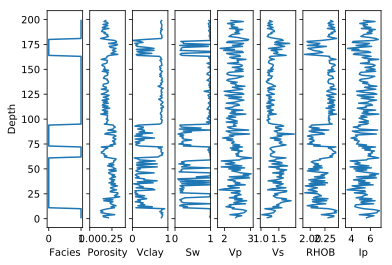

In [4]:
# Plot of loaded data

sample_number = 12
f, axarr = plt.subplots(1, 8, sharey = True)

axarr[0].plot(facies[sample_number, :], depth)
axarr[0].set_xlabel("Facies")
axarr[0].set_ylabel("Depth")

axarr[1].plot(porosity[sample_number, :], depth)
axarr[1].set_xlabel("Porosity")
axarr[1].set_xlim(0,0.4)

axarr[2].plot(vclay[sample_number, :], depth)
axarr[2].set_xlabel("Vclay")
axarr[2].set_xlim(0,1)

axarr[3].plot(Sw[sample_number, :], depth)
axarr[3].set_xlabel("Sw")
axarr[3].set_xlim(0,1)

axarr[4].plot(Vp[sample_number, :], depth)
axarr[4].set_xlabel("Vp")
# plt.xlim(0,1)

axarr[5].plot(Vs[sample_number, :], depth)
axarr[5].set_xlabel("Vs")
# plt.xlim(0,1)

axarr[6].plot(RHOB[sample_number, :], depth)
axarr[6].set_xlabel("RHOB")
# plt.xlim(0,1)

axarr[7].plot(Vp[sample_number, :]*RHOB[sample_number, :], depth)
axarr[7].set_xlabel("Ip")

In [5]:
# AVO and source parameters 
src_len=np.int(60)
freq=40
dt=7e-4
# ntheta=46
thetaStart=0
thetaEnd=30
thetaInc=5
theta=np.arange(thetaStart,thetaEnd+thetaInc,thetaInc)
ntheta=theta.size
# nt=201
# ncdp=1111
angle=np.reshape(theta,[1,ntheta])
# theta=np.arange(0,ntheta,1)
print('angle:', angle.shape)
print('angle:', angle)

angle: (1, 7)
angle: [[ 0  5 10 15 20 25 30]]


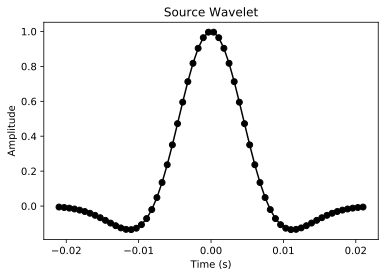

In [6]:
# Generate the seismic wavelet
def ricker(f,n,dt,t0):

    T = dt*(np.floor(n/2));
    t = np.linspace(-T,T,n)
    tau = t-t0;
    pi=np.pi
    s = (1-tau*tau*f**2*pi**2)*np.exp(-tau**2*pi**2*f**2);
    rw = s;

    return rw,t
src,tsrc=ricker(freq,src_len,dt,0)
plt.plot(tsrc,src, '-ok')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Source Wavelet")
plt.show()

In [7]:
# Full Zoeppritz using tensorflow

def gather(input1,tftheta,tfsrc):
    print('input1:',input1)
    vp = tf.expand_dims(input1[:,:,0],2)
    vs = tf.expand_dims(input1[:,:,1],2)
    rho = tf.expand_dims(input1[:,:,2],2)
    vp=tf.check_numerics(vp,"Nan at vp start")
    vs=tf.check_numerics(vs,"Nan at vp start")
    rho=tf.check_numerics(rho,"Nan at vp start")
    

    nref= tf.shape(input1)[1]#vp.get_shape()[1]#.as_list()[1]
    bs=tf.shape(input1)[0]
    ntheta=tf.shape(tftheta)[1]
    #nt=tf.shape(input1)[1]
    
    tfzero=tf.zeros([bs,1,ntheta], dtype=tf.float32)
    
    tfangle = tf.expand_dims(tf.convert_to_tensor(tftheta, 
                                                  dtype=tf.float32),0)
    tfangle=tf.tile(tfangle,[bs,nref-1,1])

  
    vp1=tf.tile(vp[:,0:nref-1],[1, 1, ntheta])
    vs1=tf.tile(vs[:,0:nref-1],[1, 1, ntheta])
    d1=tf.tile(rho[:,0:nref-1],[1, 1, ntheta])

    vp2=tf.tile(vp[:,1:nref],[1, 1, ntheta])
    vs2=tf.tile(vs[:,1:nref],[1, 1, ntheta])
    d2=tf.tile(rho[:,1:nref],[1, 1, ntheta])
    
    
    vpj1=tf.complex(vp1,tf.zeros_like(vp1))
    vsj1=tf.complex(vs1,tf.zeros_like(vs1))
    dj1=tf.complex(d1,tf.zeros_like(d1))

    vpj2=tf.complex(vp2,tf.zeros_like(vp2))
    vsj2=tf.complex(vs2,tf.zeros_like(vs2))
    dj2=tf.complex(d2,tf.zeros_like(d2))
    
    
    t=tf.scalar_mul(np.pi/180,tfangle)    
    p=tf.divide(tf.sin(t),vp1)
    ct=tf.cos(t)
    
    sint=tf.complex(tf.sin(t),tf.zeros_like(t))
    
    # FULL ZOEPPRITZ
    ct2=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vpj2),tf.square(vpj1))))))
    
    cj1=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vsj1),tf.square(vpj1))))))
    
    cj2=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vsj2),tf.square(vpj1))))))
    
    a=tf.subtract(
            tf.multiply(d2, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))),
            tf.multiply(d1, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p)))))
            )
    
    b=tf.add(
            tf.multiply(d2, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))),
            tf.multiply(d1,tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p))))
            )
    c=tf.add(
            tf.multiply(d1, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p))))),
            tf.multiply(d2,tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))
            )
    
    d=tf.scalar_mul(2.0, 
            tf.subtract(
                    tf.multiply(d2,tf.square(vs2)),
                    tf.multiply(d1,tf.square(vs1)))
            )
            
    E=tf.add(
            tf.multiply(b,tf.divide(ct,vp1)),
            tf.multiply(c,tf.divide(ct2,vp2))
            )
    F=tf.add(
            tf.multiply(b,tf.divide(cj1,vs1)),
            tf.multiply(c,tf.divide(cj2,vs2))
            )
    G=tf.subtract(a,
                  tf.divide(
                          tf.multiply(d,tf.multiply(ct,cj2)),
                          tf.multiply(vp1,vs2))
                  )
    H=tf.subtract(a,
                  tf.divide(
                          tf.multiply(d,tf.multiply(ct2,cj1)),
                          tf.multiply(vp2,vs1))
                  )
    D=tf.add(
            tf.multiply(E,F),
            tf.multiply(G,tf.multiply(H,tf.square(p)))
            )
    
    Rpp=tf.real(tf.divide(tf.subtract(
            tf.multiply(tf.subtract( tf.multiply(b,tf.divide(ct,vp1)), tf.multiply(c,tf.divide(ct2,vp2))),F),
            tf.multiply( tf.add(a, tf.multiply(d,tf.multiply(ct,tf.divide(cj2,tf.multiply(vp1,vs2))))) ,tf.multiply(H,tf.square(p)))            
            ),D))
    #print('Rpp1:',Rpp)
    Rpp=tf.concat([Rpp,tfzero],1)
    #print('Rpp2:',Rpp)
    # Rpp1=tf.zeros()
    Rpp1=tf.expand_dims(Rpp,axis=3)
    #Rpp1=tf.where(tf.is_nan(Rpp1), tf.zeros_like(Rpp1), Rpp1)
    #print('Rpp11:',Rpp1)
    #print('tfsrc:',tfsrc)
    seis=tf.transpose(tf.nn.conv2d(Rpp1,tfsrc,strides=[1,1,1,1],padding='SAME'),perm=[0,2,1,3])
    #print("seis:",seis)
    seis=tf.reshape(seis,[-1,nt*ntheta])
    #seis=tf.Print(seis,[tf.shape(seis)])

    #print('seis:',seis)
    
    return seis,Rpp

In [8]:
# Convert all logs from depth to time 
time = np.zeros((Vp.shape[0], Vp.shape[1]+1))

for i in range(time.shape[0]):
    depth_diff = np.mean(np.diff(depth.T))
    time[i,0] = 0
    time[i,1:] = 2*np.cumsum(depth_diff/(Vp[i,:]*1e3))

time = time[:,0:-1]
# Interpolate the time values such that all logs have the same dt_log
end_time = (np.max(time))
time_upscaled = np.arange(0, end_time, dt)

Vp_time = np.zeros((Vp.shape[0], time_upscaled.shape[0]))
Vs_time = np.zeros((Vs.shape[0], time_upscaled.shape[0]))
RHOB_time = np.zeros((RHOB.shape[0], time_upscaled.shape[0]))
for i in range(time.shape[0]):
    Vp_time[i,:] = np.interp(time_upscaled, time[i,:], Vp[i,:])
    Vs_time[i,:] = np.interp(time_upscaled, time[i,:], Vs[i,:])
    RHOB_time[i,:] = np.interp(time_upscaled, time[i,:], RHOB[i,:])
    
nt = time_upscaled.shape[0]    

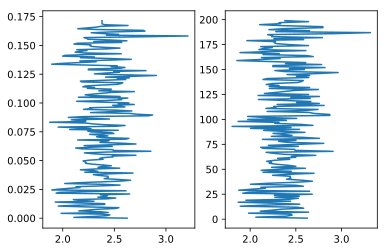

In [9]:
sample_number = 10
plt.subplot(1,2,1)
plt.plot(Vp_time[sample_number,:], time_upscaled)
plt.subplot(1,2,2)
plt.plot(Vp[sample_number,:], depth)


input1: Tensor("Const:0", shape=(2500, 246, 3), dtype=float32)


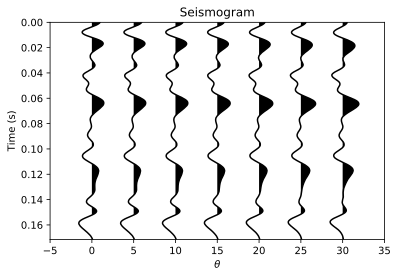

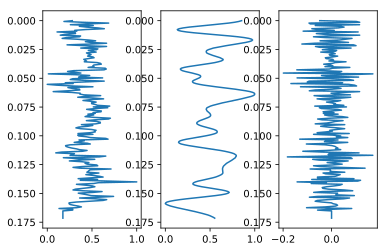

In [10]:
# Forward modeling results (Seismic gathers)

# Test the forward modeling
bs=Vp_time.shape[0]
input11=np.zeros([bs,nt,3],dtype=np.float32)

input11[0:bs,:,0]=Vp_time[0:bs,:]
input11[0:bs,:,1]=Vs_time[0:bs,:]
input11[0:bs,:,2]=RHOB_time[0:bs,:]
# plt.plot(np.squeeze(input11))
# plt.show()

input111=tf.convert_to_tensor(input11,dtype=tf.float32)
# print("src:",src.shape)


tfsrc=tf.reshape(tf.constant(src,dtype=tf.float32),[src_len,1,1,1])


# print('tfsrc:',tfsrc)
# print('angle:',angle.shape)
tftheta=tf.convert_to_tensor(angle,dtype=tf.float32)
# print('tftheta:',tftheta)
seisgen=gather(input111,tftheta,tfsrc)


sess=tf.Session()
seis11,Rpp11=sess.run(seisgen)

sess.close()

seis=np.transpose(np.reshape(seis11,[-1,ntheta,nt]),[0,2,1])
Rpp=Rpp11#np.reshape(Rpp11,[bs,nt,ntheta])

sample_number = 20
wiggle(np.squeeze(seis[sample_number,:,:]),time_upscaled,theta)
plt.title("Seismogram")
plt.xlabel("$\\theta$")
plt.ylabel("Time (s)")
plt.show()

impedance_time = Vp_time * RHOB_time
impedance_time_sample = impedance_time[sample_number,:]
plt.subplot(1,3,1)
plt.plot((impedance_time_sample - np.min(impedance_time_sample))/(np.max(impedance_time_sample)-np.min(impedance_time_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,2)
seis_sample = np.squeeze(seis[sample_number,:,0])
plt.plot((seis_sample - np.min(seis_sample))/(np.max(seis_sample) - np.min(seis_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,3)
plt.plot(np.squeeze(Rpp[sample_number,:,0]), time_upscaled)
plt.gca().invert_yaxis()

In [11]:
# Import keras modules for CNN

from keras import layers, initializers, optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling1D, MaxPooling2D, Dropout, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import LeakyReLU, Reshape
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils, normalize
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.utils import np_utils
# from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')

import sklearn.model_selection
import pydot

Using TensorFlow backend.


In [12]:
# Getting the input data (normalized) and output data 

# Reshape seismic gathers into (number of examples, angle, time) and normalize such that seismic traces have positive values
seis_reshaped = np.swapaxes(seis,1,2)
seis_reshaped_normalized = (seis_reshaped - np.min(seis_reshaped))/(np.max(seis_reshaped)-np.min(seis_reshaped))

# Concatenate Vp, Vs and Density 
num_examples = Vp_time.shape[0]
emodel = np.concatenate((Vp_time,Vs_time,RHOB_time), axis=1)
emodel = emodel.reshape((num_examples, 3, nt))


# Concatenate Porosity, Vclay, Sw 
num_examples = porosity.shape[0]
ndepth = porosity.shape[1]
petromodel = np.concatenate((porosity,vclay,Sw), axis=1)
petromodel = petromodel.reshape((num_examples, 3, ndepth))

# Split data into train and test set - elastic model
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(seis_reshaped_normalized, 
                                                                            emodel, test_size=0.2, random_state=1)
# # Normalizing output
# Y_train = normalize(Y_train, axis=2, order=2)
# Y_test = normalize(Y_test, axis=2, order=2)

# Split data into train and test set - petro model
X_train_petro, X_test_petro, Y_train_petro, Y_test_petro = sklearn.model_selection.train_test_split(seis_reshaped_normalized, 
                                                                            petromodel, test_size=0.2, random_state=1)

# Add 4th dimension of number of channels=1 to the input data
X_train = np.expand_dims(X_train, axis=3)
# # X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)

# Add 4th dimension of number of channels=1 to the input data
X_train_petro = np.expand_dims(X_train_petro, axis=3)
# # X_val = np.expand_dims(X_val, axis=3)
X_test_petro = np.expand_dims(X_test_petro, axis=3)

print ("number of training examples = " + str(X_train.shape[0]))
# print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
# print ("X_val shape: " + str(X_val.shape))
# print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

print ("number of training examples petromodel = " + str(X_train_petro.shape[0]))
# print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples petromodel = " + str(X_test_petro.shape[0]))
print ("X_train_petromodel shape: " + str(X_train_petro.shape))
print ("Y_train_petromodel shape: " + str(Y_train_petro.shape))
# print ("X_val shape: " + str(X_val.shape))
# print ("Y_val shape: " + str(Y_val.shape))
print ("X_test_petromodel shape: " + str(X_test_petro.shape))
print ("Y_test_petromodel shape: " + str(Y_test_petro.shape))

number of training examples = 2000
number of test examples = 500
X_train shape: (2000, 7, 246, 1)
Y_train shape: (2000, 3, 246)
X_test shape: (500, 7, 246, 1)
Y_test shape: (500, 3, 246)
number of training examples petromodel = 2000
number of test examples petromodel = 500
X_train_petromodel shape: (2000, 7, 246, 1)
Y_train_petromodel shape: (2000, 3, 199)
X_test_petromodel shape: (500, 7, 246, 1)
Y_test_petromodel shape: (500, 3, 199)


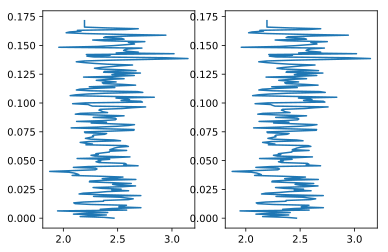

In [13]:
sample_number = 10

plt.subplot(1,2,1)
plt.plot(Y_train[sample_number, 0, :], time_upscaled)

plt.subplot(1,2,2)
plt.plot(Y_train[sample_number, 0, :], time_upscaled)

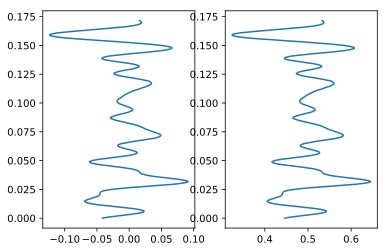

In [14]:
seis_reshaped_normalized = (seis_reshaped - np.min(seis_reshaped))/(np.max(seis_reshaped)-np.min(seis_reshaped))

plt.subplot(1,2,1)
plt.plot(np.squeeze(seis_reshaped[2,1,:]),time_upscaled)
plt.subplot(1,2,2)
plt.plot(np.squeeze(seis_reshaped_normalized[2,1,:]),time_upscaled)

In [106]:
# Building neural network for elastic properties prediction in Keras 
given_seed = 3 # For repeatibility

def elasticnet(input_shape):
    """
    Implementation of the AVONet.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    # Define the input placeholder as a tensor with shape input_shape. Input = input angle gather 
    X_input = Input(input_shape)

    X = X_input

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(60, (3, 61), strides=(1, 1), name='conv0',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
#     X = MaxPooling2D((3, 3), strides=(1,1),name='max_pool0', padding = 'same')(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(1, (3, 61), strides=(1, 1), name='conv1',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn1')(X)
    X = Activation('relu')(X)

    # MAXPOOL
#     X = MaxPooling2D((3, 3), strides=(1,1),name='max_pool1', padding = 'same')(X)
      

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
#     X = Dense(1200, name='fc1')(X)
#     X = Activation('relu')(X)
    X = Dense(246*3, name='fc1')(X)
    X = Activation('relu')(X)
    
    X = Reshape((3, 246))(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='ElasticModel')

    return model
    ### END CODE HERE ###

In [107]:
# Create the model
ElasticModel = elasticnet(X_train.shape[1:])


In [108]:
# Summary and plot of the model

ElasticModel.summary()


# plot_model(AVOModel)
# SVG(model_to_dot(ElasticModel).create(prog='dot', format='svg'))
# plot_model(ElasticModel, to_file='./Figures/model_plot.png', show_shapes=True, show_layer_names=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 7, 246, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 5, 186, 60)        11040     
_________________________________________________________________
bn0 (BatchNormalization)     (None, 5, 186, 60)        240       
_________________________________________________________________
activation_16 (Activation)   (None, 5, 186, 60)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 3, 126, 1)         10981     
_________________________________________________________________
bn1 (BatchNormalization)     (None, 3, 126, 1)         4         
_________________________________________________________________
activation_17 (Activation)   (None, 3, 126, 1)         0         
__________

In [109]:
# Learning rate scheduler
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.1
    epochs_drop = 250.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [112]:
# Compile the model with optimization algorithm, loss function
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

ElasticModel.compile(loss='mean_squared_error', optimizer = adam)

In [113]:
# Start the training
# Using learning rate scheduler
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
history = ElasticModel.fit(X_train, Y_train, validation_split=0.2, epochs=2000, batch_size=32, callbacks=callbacks_list)

# history = ElasticModel.fit(X_train, Y_train, validation_split=0.5, epochs=1500, batch_size=32)

Train on 1600 samples, validate on 400 samples
Epoch 1/2000
1600/1600 [==============================] - 3s 2ms/step - loss: 0.2894 - val_loss: 0.4439
Epoch 2/2000
1600/1600 [==============================] - 1s 811us/step - loss: 0.0530 - val_loss: 0.1372
Epoch 3/2000
1600/1600 [==============================] - 1s 808us/step - loss: 0.0496 - val_loss: 0.6706
Epoch 4/2000
1600/1600 [==============================] - 1s 810us/step - loss: 0.0529 - val_loss: 1.2219
Epoch 5/2000
1600/1600 [==============================] - 1s 814us/step - loss: 0.0513 - val_loss: 0.0797
Epoch 6/2000
1600/1600 [==============================] - 1s 816us/step - loss: 0.0573 - val_loss: 0.0538
Epoch 7/2000
1600/1600 [==============================] - 1s 811us/step - loss: 0.0488 - val_loss: 0.9759
Epoch 8/2000
1600/1600 [==============================] - 1s 811us/step - loss: 0.0478 - val_loss: 0.4428
Epoch 9/2000
1600/1600 [==============================] - 1s 811us/step - loss: 0.0481 - val_loss: 1.2883
E

1600/1600 [==============================] - 1s 814us/step - loss: 0.0219 - val_loss: 0.0338
Epoch 154/2000
1600/1600 [==============================] - 1s 821us/step - loss: 0.0218 - val_loss: 0.0328
Epoch 155/2000
1600/1600 [==============================] - 1s 813us/step - loss: 0.0217 - val_loss: 0.0349
Epoch 156/2000
1600/1600 [==============================] - 1s 809us/step - loss: 0.0217 - val_loss: 0.0362
Epoch 157/2000
1600/1600 [==============================] - 1s 818us/step - loss: 0.0217 - val_loss: 0.0330
Epoch 158/2000
1600/1600 [==============================] - 1s 813us/step - loss: 0.0216 - val_loss: 0.0365
Epoch 159/2000
1600/1600 [==============================] - 1s 815us/step - loss: 0.0217 - val_loss: 0.0263
Epoch 160/2000
1600/1600 [==============================] - 1s 821us/step - loss: 0.0215 - val_loss: 0.0280
Epoch 161/2000
1600/1600 [==============================] - 1s 813us/step - loss: 0.0216 - val_loss: 0.0367
Epoch 162/2000
1600/1600 [=================

Epoch 229/2000
1600/1600 [==============================] - 1s 825us/step - loss: 0.0188 - val_loss: 0.0230
Epoch 230/2000
1600/1600 [==============================] - 1s 810us/step - loss: 0.0187 - val_loss: 0.0239
Epoch 231/2000
1600/1600 [==============================] - 1s 817us/step - loss: 0.0186 - val_loss: 0.0252
Epoch 232/2000
1600/1600 [==============================] - 1s 812us/step - loss: 0.0187 - val_loss: 0.0262
Epoch 233/2000
1600/1600 [==============================] - 1s 812us/step - loss: 0.0187 - val_loss: 0.0238
Epoch 234/2000
1600/1600 [==============================] - 1s 820us/step - loss: 0.0187 - val_loss: 0.0273
Epoch 235/2000
1600/1600 [==============================] - 1s 814us/step - loss: 0.0186 - val_loss: 0.0275
Epoch 236/2000
1600/1600 [==============================] - 1s 814us/step - loss: 0.0186 - val_loss: 0.0352
Epoch 237/2000
1600/1600 [==============================] - 1s 808us/step - loss: 0.0188 - val_loss: 0.0237
Epoch 238/2000
1600/1600 [==

Epoch 305/2000
1600/1600 [==============================] - 1s 806us/step - loss: 0.0170 - val_loss: 0.0235
Epoch 306/2000
1600/1600 [==============================] - 1s 821us/step - loss: 0.0170 - val_loss: 0.0231
Epoch 307/2000
1600/1600 [==============================] - 1s 813us/step - loss: 0.0170 - val_loss: 0.0233
Epoch 308/2000
1600/1600 [==============================] - 1s 809us/step - loss: 0.0170 - val_loss: 0.0240
Epoch 309/2000
1600/1600 [==============================] - 1s 811us/step - loss: 0.0170 - val_loss: 0.0235
Epoch 310/2000
1600/1600 [==============================] - 1s 810us/step - loss: 0.0170 - val_loss: 0.0232
Epoch 311/2000
1600/1600 [==============================] - 1s 817us/step - loss: 0.0170 - val_loss: 0.0231
Epoch 312/2000
1600/1600 [==============================] - 1s 808us/step - loss: 0.0170 - val_loss: 0.0237
Epoch 313/2000
1600/1600 [==============================] - 1s 812us/step - loss: 0.0170 - val_loss: 0.0233
Epoch 314/2000
1600/1600 [==

Epoch 381/2000
1600/1600 [==============================] - 1s 809us/step - loss: 0.0167 - val_loss: 0.0238
Epoch 382/2000
1600/1600 [==============================] - 1s 807us/step - loss: 0.0168 - val_loss: 0.0234
Epoch 383/2000
1600/1600 [==============================] - 1s 814us/step - loss: 0.0168 - val_loss: 0.0238
Epoch 384/2000
1600/1600 [==============================] - 1s 814us/step - loss: 0.0168 - val_loss: 0.0249
Epoch 385/2000
1600/1600 [==============================] - 1s 809us/step - loss: 0.0167 - val_loss: 0.0240
Epoch 386/2000
1600/1600 [==============================] - 1s 820us/step - loss: 0.0167 - val_loss: 0.0237
Epoch 387/2000
1600/1600 [==============================] - 1s 839us/step - loss: 0.0167 - val_loss: 0.0237
Epoch 388/2000
1600/1600 [==============================] - 1s 826us/step - loss: 0.0167 - val_loss: 0.0244
Epoch 389/2000
1600/1600 [==============================] - 1s 813us/step - loss: 0.0167 - val_loss: 0.0234
Epoch 390/2000
1600/1600 [==

Epoch 457/2000
1600/1600 [==============================] - 1s 812us/step - loss: 0.0166 - val_loss: 0.0239
Epoch 458/2000
1600/1600 [==============================] - 1s 811us/step - loss: 0.0166 - val_loss: 0.0239
Epoch 459/2000
1600/1600 [==============================] - 1s 813us/step - loss: 0.0165 - val_loss: 0.0240
Epoch 460/2000
1600/1600 [==============================] - 1s 808us/step - loss: 0.0165 - val_loss: 0.0237
Epoch 461/2000
1600/1600 [==============================] - 1s 810us/step - loss: 0.0166 - val_loss: 0.0237
Epoch 462/2000
1600/1600 [==============================] - 1s 806us/step - loss: 0.0166 - val_loss: 0.0243
Epoch 463/2000
1600/1600 [==============================] - 1s 807us/step - loss: 0.0166 - val_loss: 0.0239
Epoch 464/2000
1600/1600 [==============================] - 1s 813us/step - loss: 0.0165 - val_loss: 0.0241
Epoch 465/2000
1600/1600 [==============================] - 1s 812us/step - loss: 0.0165 - val_loss: 0.0242
Epoch 466/2000
1600/1600 [==

Epoch 533/2000
1600/1600 [==============================] - 1s 808us/step - loss: 0.0162 - val_loss: 0.0238
Epoch 534/2000
1600/1600 [==============================] - 1s 809us/step - loss: 0.0162 - val_loss: 0.0238
Epoch 535/2000
1600/1600 [==============================] - 1s 808us/step - loss: 0.0162 - val_loss: 0.0238
Epoch 536/2000
1600/1600 [==============================] - 1s 808us/step - loss: 0.0162 - val_loss: 0.0238
Epoch 537/2000
1600/1600 [==============================] - 1s 807us/step - loss: 0.0163 - val_loss: 0.0238
Epoch 538/2000
1600/1600 [==============================] - 1s 811us/step - loss: 0.0163 - val_loss: 0.0238
Epoch 539/2000
1600/1600 [==============================] - 1s 805us/step - loss: 0.0162 - val_loss: 0.0238
Epoch 540/2000
1600/1600 [==============================] - 1s 807us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 541/2000
1600/1600 [==============================] - 1s 805us/step - loss: 0.0162 - val_loss: 0.0238
Epoch 542/2000
1600/1600 [==

Epoch 609/2000
1600/1600 [==============================] - 1s 810us/step - loss: 0.0162 - val_loss: 0.0238
Epoch 610/2000
1600/1600 [==============================] - 1s 816us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 611/2000
1600/1600 [==============================] - 1s 809us/step - loss: 0.0162 - val_loss: 0.0238
Epoch 612/2000
1600/1600 [==============================] - 1s 809us/step - loss: 0.0162 - val_loss: 0.0238
Epoch 613/2000
1600/1600 [==============================] - 1s 812us/step - loss: 0.0162 - val_loss: 0.0238
Epoch 614/2000
1600/1600 [==============================] - 1s 812us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 615/2000
1600/1600 [==============================] - 1s 809us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 616/2000
1600/1600 [==============================] - 1s 812us/step - loss: 0.0162 - val_loss: 0.0238
Epoch 617/2000
1600/1600 [==============================] - 1s 808us/step - loss: 0.0162 - val_loss: 0.0238
Epoch 618/2000
1600/1600 [==

Epoch 685/2000
1600/1600 [==============================] - 1s 807us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 686/2000
1600/1600 [==============================] - 1s 819us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 687/2000
1600/1600 [==============================] - 1s 807us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 688/2000
1600/1600 [==============================] - 1s 811us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 689/2000
1600/1600 [==============================] - 1s 813us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 690/2000
1600/1600 [==============================] - 1s 810us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 691/2000
1600/1600 [==============================] - 1s 813us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 692/2000
1600/1600 [==============================] - 1s 810us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 693/2000
1600/1600 [==============================] - 1s 810us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 694/2000
1600/1600 [==

Epoch 761/2000
1600/1600 [==============================] - 1s 814us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 762/2000
1600/1600 [==============================] - 1s 814us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 763/2000
1600/1600 [==============================] - 1s 814us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 764/2000
1600/1600 [==============================] - 1s 807us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 765/2000
1600/1600 [==============================] - 1s 810us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 766/2000
1600/1600 [==============================] - 1s 814us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 767/2000
1600/1600 [==============================] - 1s 807us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 768/2000
1600/1600 [==============================] - 1s 817us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 769/2000
1600/1600 [==============================] - 1s 807us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 770/2000
1600/1600 [==

Epoch 837/2000
1600/1600 [==============================] - 1s 819us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 838/2000
1600/1600 [==============================] - 1s 811us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 839/2000
1600/1600 [==============================] - 1s 808us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 840/2000
1600/1600 [==============================] - 1s 817us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 841/2000
1600/1600 [==============================] - 1s 810us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 842/2000
1600/1600 [==============================] - 1s 812us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 843/2000
1600/1600 [==============================] - 1s 812us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 844/2000
1600/1600 [==============================] - 1s 810us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 845/2000
1600/1600 [==============================] - 1s 816us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 846/2000
1600/1600 [==

Epoch 913/2000
1600/1600 [==============================] - 1s 816us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 914/2000
1600/1600 [==============================] - 1s 816us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 915/2000
1600/1600 [==============================] - 1s 815us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 916/2000
1600/1600 [==============================] - 1s 813us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 917/2000
1600/1600 [==============================] - 1s 813us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 918/2000
1600/1600 [==============================] - 1s 810us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 919/2000
1600/1600 [==============================] - 1s 821us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 920/2000
1600/1600 [==============================] - 1s 827us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 921/2000
1600/1600 [==============================] - 1s 819us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 922/2000
1600/1600 [==

Epoch 989/2000
1600/1600 [==============================] - 1s 823us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 990/2000
1600/1600 [==============================] - 1s 811us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 991/2000
1600/1600 [==============================] - 1s 815us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 992/2000
1600/1600 [==============================] - 1s 812us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 993/2000
1600/1600 [==============================] - 1s 811us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 994/2000
1600/1600 [==============================] - 1s 810us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 995/2000
1600/1600 [==============================] - 1s 816us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 996/2000
1600/1600 [==============================] - 1s 810us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 997/2000
1600/1600 [==============================] - 1s 809us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 998/2000
1600/1600 [==

1600/1600 [==============================] - 1s 817us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 1140/2000
1600/1600 [==============================] - 1s 820us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1141/2000
1600/1600 [==============================] - 1s 814us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1142/2000
1600/1600 [==============================] - 1s 816us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1143/2000
1600/1600 [==============================] - 1s 813us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1144/2000
1600/1600 [==============================] - 1s 815us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1145/2000
1600/1600 [==============================] - 1s 812us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1146/2000
1600/1600 [==============================] - 1s 812us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1147/2000
1600/1600 [==============================] - 1s 818us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1148/2000
1600/1600 [========

1600/1600 [==============================] - 1s 813us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1290/2000
1600/1600 [==============================] - 1s 818us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 1291/2000
1600/1600 [==============================] - 1s 816us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1292/2000
1600/1600 [==============================] - 1s 817us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 1293/2000
1600/1600 [==============================] - 1s 817us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1294/2000
1600/1600 [==============================] - 1s 818us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1295/2000
1600/1600 [==============================] - 1s 816us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1296/2000
1600/1600 [==============================] - 1s 812us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1297/2000
1600/1600 [==============================] - 1s 814us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1298/2000
1600/1600 [========

1600/1600 [==============================] - 1s 816us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1440/2000
1600/1600 [==============================] - 1s 815us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1441/2000
1600/1600 [==============================] - 1s 819us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1442/2000
1600/1600 [==============================] - 1s 810us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1443/2000
1600/1600 [==============================] - 1s 817us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 1444/2000
1600/1600 [==============================] - 1s 812us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1445/2000
1600/1600 [==============================] - 1s 812us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1446/2000
1600/1600 [==============================] - 1s 814us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1447/2000
1600/1600 [==============================] - 1s 813us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 1448/2000
1600/1600 [========

1600/1600 [==============================] - 1s 810us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1590/2000
1600/1600 [==============================] - 1s 811us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1591/2000
1600/1600 [==============================] - 1s 808us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1592/2000
1600/1600 [==============================] - 1s 807us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1593/2000
1600/1600 [==============================] - 1s 811us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1594/2000
1600/1600 [==============================] - 1s 810us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1595/2000
1600/1600 [==============================] - 1s 814us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1596/2000
1600/1600 [==============================] - 1s 809us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1597/2000
1600/1600 [==============================] - 1s 806us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1598/2000
1600/1600 [========

1600/1600 [==============================] - 1s 810us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1740/2000
1600/1600 [==============================] - 1s 812us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1741/2000
1600/1600 [==============================] - 1s 815us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 1742/2000
1600/1600 [==============================] - 1s 810us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1743/2000
1600/1600 [==============================] - 1s 815us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1744/2000
1600/1600 [==============================] - 1s 809us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1745/2000
1600/1600 [==============================] - 1s 815us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1746/2000
1600/1600 [==============================] - 1s 805us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1747/2000
1600/1600 [==============================] - 1s 817us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 1748/2000
1600/1600 [========

1600/1600 [==============================] - 1s 807us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 1890/2000
1600/1600 [==============================] - 1s 807us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 1891/2000
1600/1600 [==============================] - 1s 808us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1892/2000
1600/1600 [==============================] - 1s 812us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1893/2000
1600/1600 [==============================] - 1s 810us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1894/2000
1600/1600 [==============================] - 1s 812us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1895/2000
1600/1600 [==============================] - 1s 812us/step - loss: 0.0161 - val_loss: 0.0239
Epoch 1896/2000
1600/1600 [==============================] - 1s 815us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 1897/2000
1600/1600 [==============================] - 1s 805us/step - loss: 0.0162 - val_loss: 0.0239
Epoch 1898/2000
1600/1600 [========

In [127]:
# Testing and evaluating the model
preds = ElasticModel.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)
print()
print ("Loss = " + str(preds))
# print ("Test Accuracy = " + str(preds[1]))

500/500 [==============================] - 0s 524us/step

Loss = 0.023818197101354598


0.14775758481025697

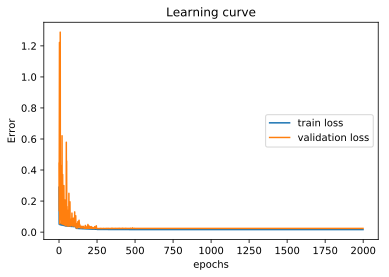

In [126]:
# Plotting the learning curve 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])


plt.title('Learning curve')
# plt.ylabel('Error/Accuracy')
plt.ylabel('Error')
plt.xlabel('epochs')
plt.legend(['train loss', 'validation loss'], loc='center right')
# plt.savefig('/Figures/learning_curve_08Nov.png', bbox_inches='tight')

In [122]:
# Save trained model 
# serialize model to JSON
model_json = ElasticModel.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
ElasticModel.save_weights("ElasticModel.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# Load saved model
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
ElasticModel = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("ElasticModel.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

ElasticModel.compile(loss='mean_squared_error', optimizer = adam)


# To evaluate run the "Testing and evaluating the model" cell

In [119]:
# Predict training and test data using the trained network
test_output = ElasticModel.predict(X_test)
train_output = ElasticModel.predict(X_train)

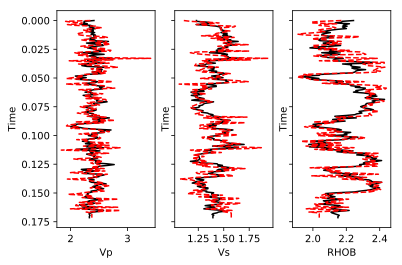

In [120]:
# Checking training data

sample_number = 15
f, axarr = plt.subplots(1, 3, sharey = True)

axarr[0].plot(train_output[sample_number, 0, :], time_upscaled, '-k')
axarr[0].plot(Y_train[sample_number, 0, :], time_upscaled, '--r')
axarr[0].set_xlabel("Vp")
axarr[0].set_ylabel("Time")
axarr[0].invert_yaxis()
# axarr[0].set_xlim(1.5,3.1)

axarr[1].plot(train_output[sample_number, 1, :], time_upscaled, '-k')
axarr[1].plot(Y_train[sample_number, 1, :], time_upscaled, '--r')
axarr[1].set_xlabel("Vs")
axarr[1].set_ylabel("Time")
axarr[1].invert_yaxis()
# axarr[1].set_xlim(1,2)

axarr[2].plot(train_output[sample_number, 2, :], time_upscaled, '-k')
axarr[2].plot(Y_train[sample_number, 2, :], time_upscaled, '--r')
axarr[2].set_xlabel("RHOB")
axarr[2].set_ylabel("Time")
axarr[2].invert_yaxis()
# axarr[2].set_xlim(1.5,3)

(1.5, 3)

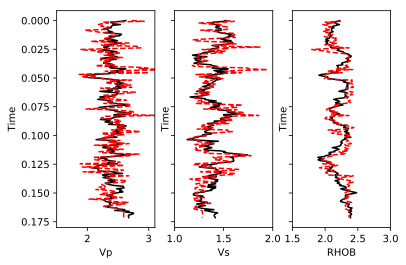

In [121]:
# Checking testing data

sample_number = 12
f, axarr = plt.subplots(1, 3, sharey = True)

axarr[0].plot(test_output[sample_number, 0, :], time_upscaled, '-k')
axarr[0].plot(Y_test[sample_number, 0, :], time_upscaled, '--r')
axarr[0].set_xlabel("Vp")
axarr[0].set_ylabel("Time")
axarr[0].invert_yaxis()
axarr[0].set_xlim(1.5,3.1)

axarr[1].plot(test_output[sample_number, 1, :], time_upscaled, '-k')
axarr[1].plot(Y_test[sample_number, 1, :], time_upscaled, '--r')
axarr[1].set_xlabel("Vs")
axarr[1].set_ylabel("Time")
axarr[1].invert_yaxis()
axarr[1].set_xlim(1,2)

axarr[2].plot(test_output[sample_number, 2, :], time_upscaled, '-k')
axarr[2].plot(Y_test[sample_number, 2, :], time_upscaled, '--r')
axarr[2].set_xlabel("RHOB")
axarr[2].set_ylabel("Time")
axarr[2].invert_yaxis()
axarr[2].set_xlim(1.5,3)

In [35]:
# Building neural network for petrophysical properties prediction in Keras 
given_seed = 3 # For repeatibility

def petronet(input_shape):
    """
    Implementation of the PetroNet.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    # Define the input placeholder as a tensor with shape input_shape. Input = input angle gather 
    X_input = Input(input_shape)

    X = X_input

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(60, (3, 45), strides=(1, 1), name='conv0',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
#     X = MaxPooling2D((3, 3), strides=(1,1),name='max_pool0', padding = 'same')(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(1, (3, 45), strides=(1, 1), name='conv1',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn1')(X)
    X = Activation('relu')(X)

    # MAXPOOL
#     X = MaxPooling2D((3, 3), strides=(1,1),name='max_pool1', padding = 'same')(X)
      

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
#     X = Dense(1200, name='fc1')(X)
#     X = Activation('relu')(X)
    X = Dense(199*3, name='fc1')(X)
    X = Activation('relu')(X)
    
    X = Reshape((3, 199))(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='ElasticModel')

    return model
    ### END CODE HERE ###

In [36]:
# Create the model
PetroModel = petronet(X_train.shape[1:])

In [37]:
# Summary and plot of the model

PetroModel.summary()


# plot_model(AVOModel)
# SVG(model_to_dot(ElasticModel).create(prog='dot', format='svg'))
# plot_model(ElasticModel, to_file='./Figures/model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 7, 246, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 5, 202, 60)        8160      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 5, 202, 60)        240       
_________________________________________________________________
activation_10 (Activation)   (None, 5, 202, 60)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 3, 158, 1)         8101      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 3, 158, 1)         4         
_________________________________________________________________
activation_11 (Activation)   (None, 3, 158, 1)         0         
__________

In [38]:
# Learning rate scheduler
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.1
    epochs_drop = 250.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [39]:
# Compile the model with optimization algorithm, loss function
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

PetroModel.compile(loss='mean_squared_error', optimizer = adam)

In [40]:
# Start the training
# Using learning rate scheduler
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
history = PetroModel.fit(X_train_petro, Y_train_petro, 
                         validation_split=0.2, epochs=1000, batch_size=32, callbacks=callbacks_list)

# history = ElasticModel.fit(X_train, Y_train, validation_split=0.5, epochs=1500, batch_size=32)

Train on 1600 samples, validate on 400 samples
Epoch 1/1000
1600/1600 [==============================] - 2s 1ms/step - loss: 0.1872 - val_loss: 0.3609
Epoch 2/1000
1600/1600 [==============================] - 1s 736us/step - loss: 0.1340 - val_loss: 0.3411
Epoch 3/1000
1600/1600 [==============================] - 1s 734us/step - loss: 0.1312 - val_loss: 0.3197
Epoch 4/1000
1600/1600 [==============================] - 1s 737us/step - loss: 0.1294 - val_loss: 0.2772
Epoch 5/1000
1600/1600 [==============================] - 1s 746us/step - loss: 0.1303 - val_loss: 0.1855
Epoch 6/1000
1600/1600 [==============================] - 1s 740us/step - loss: 0.1265 - val_loss: 0.2261
Epoch 7/1000
1600/1600 [==============================] - 1s 739us/step - loss: 0.1255 - val_loss: 0.2391
Epoch 8/1000
1600/1600 [==============================] - 1s 740us/step - loss: 0.1246 - val_loss: 0.2203
Epoch 9/1000
1600/1600 [==============================] - 1s 738us/step - loss: 0.1245 - val_loss: 0.1658
E

1600/1600 [==============================] - 1s 739us/step - loss: 0.1128 - val_loss: 0.1251
Epoch 78/1000
1600/1600 [==============================] - 1s 750us/step - loss: 0.1122 - val_loss: 0.1219
Epoch 79/1000
1600/1600 [==============================] - 1s 746us/step - loss: 0.1123 - val_loss: 0.1253
Epoch 80/1000
1600/1600 [==============================] - 1s 741us/step - loss: 0.1124 - val_loss: 0.1241
Epoch 81/1000
1600/1600 [==============================] - 1s 743us/step - loss: 0.1124 - val_loss: 0.1386
Epoch 82/1000
1600/1600 [==============================] - 1s 743us/step - loss: 0.1121 - val_loss: 0.1496
Epoch 83/1000
1600/1600 [==============================] - 1s 743us/step - loss: 0.1120 - val_loss: 0.1252
Epoch 84/1000
1600/1600 [==============================] - 1s 745us/step - loss: 0.1122 - val_loss: 0.1339
Epoch 85/1000
1600/1600 [==============================] - 1s 746us/step - loss: 0.1121 - val_loss: 0.1382
Epoch 86/1000
1600/1600 [==========================

1600/1600 [==============================] - 1s 743us/step - loss: 0.1080 - val_loss: 0.1226
Epoch 154/1000
1600/1600 [==============================] - 1s 744us/step - loss: 0.1083 - val_loss: 0.1258
Epoch 155/1000
1600/1600 [==============================] - 1s 744us/step - loss: 0.1081 - val_loss: 0.1285
Epoch 156/1000
1600/1600 [==============================] - 1s 742us/step - loss: 0.1081 - val_loss: 0.1293
Epoch 157/1000
1600/1600 [==============================] - 1s 738us/step - loss: 0.1082 - val_loss: 0.1347
Epoch 158/1000
1600/1600 [==============================] - 1s 745us/step - loss: 0.1082 - val_loss: 0.1286
Epoch 159/1000
1600/1600 [==============================] - 1s 742us/step - loss: 0.1081 - val_loss: 0.1214
Epoch 160/1000
1600/1600 [==============================] - 1s 740us/step - loss: 0.1079 - val_loss: 0.1245
Epoch 161/1000
1600/1600 [==============================] - 1s 747us/step - loss: 0.1077 - val_loss: 0.1212
Epoch 162/1000
1600/1600 [=================

Epoch 229/1000
1600/1600 [==============================] - 1s 749us/step - loss: 0.1061 - val_loss: 0.1234
Epoch 230/1000
1600/1600 [==============================] - 1s 751us/step - loss: 0.1065 - val_loss: 0.1233
Epoch 231/1000
1600/1600 [==============================] - 1s 747us/step - loss: 0.1061 - val_loss: 0.1276
Epoch 232/1000
1600/1600 [==============================] - 1s 747us/step - loss: 0.1062 - val_loss: 0.1265
Epoch 233/1000
1600/1600 [==============================] - 1s 747us/step - loss: 0.1068 - val_loss: 0.1364
Epoch 234/1000
1600/1600 [==============================] - 1s 741us/step - loss: 0.1060 - val_loss: 0.1267
Epoch 235/1000
1600/1600 [==============================] - 1s 743us/step - loss: 0.1060 - val_loss: 0.1236
Epoch 236/1000
1600/1600 [==============================] - 1s 744us/step - loss: 0.1058 - val_loss: 0.1277
Epoch 237/1000
1600/1600 [==============================] - 1s 747us/step - loss: 0.1061 - val_loss: 0.1235
Epoch 238/1000
1600/1600 [==

Epoch 305/1000
1600/1600 [==============================] - 1s 742us/step - loss: 0.1035 - val_loss: 0.1227
Epoch 306/1000
1600/1600 [==============================] - 1s 743us/step - loss: 0.1034 - val_loss: 0.1232
Epoch 307/1000
1600/1600 [==============================] - 1s 743us/step - loss: 0.1034 - val_loss: 0.1224
Epoch 308/1000
1600/1600 [==============================] - 1s 742us/step - loss: 0.1035 - val_loss: 0.1232
Epoch 309/1000
1600/1600 [==============================] - 1s 741us/step - loss: 0.1036 - val_loss: 0.1227
Epoch 310/1000
1600/1600 [==============================] - 1s 742us/step - loss: 0.1034 - val_loss: 0.1226
Epoch 311/1000
1600/1600 [==============================] - 1s 746us/step - loss: 0.1034 - val_loss: 0.1227
Epoch 312/1000
1600/1600 [==============================] - 1s 739us/step - loss: 0.1035 - val_loss: 0.1236
Epoch 313/1000
1600/1600 [==============================] - 1s 746us/step - loss: 0.1034 - val_loss: 0.1232
Epoch 314/1000
1600/1600 [==

Epoch 381/1000
1600/1600 [==============================] - 1s 749us/step - loss: 0.1032 - val_loss: 0.1234
Epoch 382/1000
1600/1600 [==============================] - 1s 742us/step - loss: 0.1031 - val_loss: 0.1225
Epoch 383/1000
1600/1600 [==============================] - 1s 741us/step - loss: 0.1032 - val_loss: 0.1230
Epoch 384/1000
1600/1600 [==============================] - 1s 744us/step - loss: 0.1032 - val_loss: 0.1231
Epoch 385/1000
1600/1600 [==============================] - 1s 744us/step - loss: 0.1032 - val_loss: 0.1232
Epoch 386/1000
1600/1600 [==============================] - 1s 739us/step - loss: 0.1032 - val_loss: 0.1236
Epoch 387/1000
1600/1600 [==============================] - 1s 739us/step - loss: 0.1032 - val_loss: 0.1231
Epoch 388/1000
1600/1600 [==============================] - 1s 739us/step - loss: 0.1033 - val_loss: 0.1231
Epoch 389/1000
1600/1600 [==============================] - 1s 743us/step - loss: 0.1030 - val_loss: 0.1231
Epoch 390/1000
1600/1600 [==

Epoch 457/1000
1600/1600 [==============================] - 1s 743us/step - loss: 0.1029 - val_loss: 0.1232
Epoch 458/1000
1600/1600 [==============================] - 1s 745us/step - loss: 0.1030 - val_loss: 0.1237
Epoch 459/1000
1600/1600 [==============================] - 1s 744us/step - loss: 0.1030 - val_loss: 0.1237
Epoch 460/1000
1600/1600 [==============================] - 1s 744us/step - loss: 0.1030 - val_loss: 0.1236
Epoch 461/1000
1600/1600 [==============================] - 1s 744us/step - loss: 0.1029 - val_loss: 0.1236
Epoch 462/1000
1600/1600 [==============================] - 1s 746us/step - loss: 0.1030 - val_loss: 0.1242
Epoch 463/1000
1600/1600 [==============================] - 1s 748us/step - loss: 0.1030 - val_loss: 0.1232
Epoch 464/1000
1600/1600 [==============================] - 1s 741us/step - loss: 0.1029 - val_loss: 0.1233
Epoch 465/1000
1600/1600 [==============================] - 1s 742us/step - loss: 0.1030 - val_loss: 0.1239
Epoch 466/1000
1600/1600 [==

Epoch 533/1000
1600/1600 [==============================] - 1s 742us/step - loss: 0.1025 - val_loss: 0.1240
Epoch 534/1000
1600/1600 [==============================] - 1s 741us/step - loss: 0.1026 - val_loss: 0.1240
Epoch 535/1000
1600/1600 [==============================] - 1s 744us/step - loss: 0.1024 - val_loss: 0.1241
Epoch 536/1000
1600/1600 [==============================] - 1s 742us/step - loss: 0.1025 - val_loss: 0.1238
Epoch 537/1000
1600/1600 [==============================] - 1s 742us/step - loss: 0.1026 - val_loss: 0.1239
Epoch 538/1000
1600/1600 [==============================] - 1s 743us/step - loss: 0.1027 - val_loss: 0.1240
Epoch 539/1000
1600/1600 [==============================] - 1s 738us/step - loss: 0.1026 - val_loss: 0.1239
Epoch 540/1000
1600/1600 [==============================] - 1s 744us/step - loss: 0.1025 - val_loss: 0.1240
Epoch 541/1000
1600/1600 [==============================] - 1s 743us/step - loss: 0.1025 - val_loss: 0.1241
Epoch 542/1000
1600/1600 [==

Epoch 609/1000
1600/1600 [==============================] - 1s 744us/step - loss: 0.1025 - val_loss: 0.1241
Epoch 610/1000
1600/1600 [==============================] - 1s 748us/step - loss: 0.1026 - val_loss: 0.1241
Epoch 611/1000
1600/1600 [==============================] - 1s 753us/step - loss: 0.1027 - val_loss: 0.1240
Epoch 612/1000
1600/1600 [==============================] - 1s 753us/step - loss: 0.1025 - val_loss: 0.1239
Epoch 613/1000
1600/1600 [==============================] - 1s 751us/step - loss: 0.1025 - val_loss: 0.1239
Epoch 614/1000
1600/1600 [==============================] - 1s 752us/step - loss: 0.1025 - val_loss: 0.1240
Epoch 615/1000
1600/1600 [==============================] - 1s 751us/step - loss: 0.1024 - val_loss: 0.1242
Epoch 616/1000
1600/1600 [==============================] - 1s 753us/step - loss: 0.1025 - val_loss: 0.1240
Epoch 617/1000
1600/1600 [==============================] - 1s 753us/step - loss: 0.1025 - val_loss: 0.1240
Epoch 618/1000
1600/1600 [==

Epoch 685/1000
1600/1600 [==============================] - 1s 751us/step - loss: 0.1026 - val_loss: 0.1240
Epoch 686/1000
1600/1600 [==============================] - 1s 751us/step - loss: 0.1025 - val_loss: 0.1240
Epoch 687/1000
1600/1600 [==============================] - 1s 753us/step - loss: 0.1025 - val_loss: 0.1241
Epoch 688/1000
1600/1600 [==============================] - 1s 749us/step - loss: 0.1025 - val_loss: 0.1240
Epoch 689/1000
1600/1600 [==============================] - 1s 754us/step - loss: 0.1025 - val_loss: 0.1241
Epoch 690/1000
1600/1600 [==============================] - 1s 757us/step - loss: 0.1025 - val_loss: 0.1242
Epoch 691/1000
1600/1600 [==============================] - 1s 753us/step - loss: 0.1024 - val_loss: 0.1241
Epoch 692/1000
1600/1600 [==============================] - 1s 752us/step - loss: 0.1026 - val_loss: 0.1241
Epoch 693/1000
1600/1600 [==============================] - 1s 747us/step - loss: 0.1025 - val_loss: 0.1241
Epoch 694/1000
1600/1600 [==

Epoch 761/1000
1600/1600 [==============================] - 1s 755us/step - loss: 0.1024 - val_loss: 0.1241
Epoch 762/1000
1600/1600 [==============================] - 1s 753us/step - loss: 0.1024 - val_loss: 0.1241
Epoch 763/1000
1600/1600 [==============================] - 1s 749us/step - loss: 0.1025 - val_loss: 0.1241
Epoch 764/1000
1600/1600 [==============================] - 1s 751us/step - loss: 0.1024 - val_loss: 0.1241
Epoch 765/1000
1600/1600 [==============================] - 1s 747us/step - loss: 0.1025 - val_loss: 0.1241
Epoch 766/1000
1600/1600 [==============================] - 1s 751us/step - loss: 0.1024 - val_loss: 0.1241
Epoch 767/1000
1600/1600 [==============================] - 1s 752us/step - loss: 0.1025 - val_loss: 0.1241
Epoch 768/1000
1600/1600 [==============================] - 1s 755us/step - loss: 0.1024 - val_loss: 0.1241
Epoch 769/1000
1600/1600 [==============================] - 1s 755us/step - loss: 0.1025 - val_loss: 0.1241
Epoch 770/1000
1600/1600 [==

Epoch 837/1000
1600/1600 [==============================] - 1s 755us/step - loss: 0.1025 - val_loss: 0.1241
Epoch 838/1000
1600/1600 [==============================] - 1s 752us/step - loss: 0.1025 - val_loss: 0.1241
Epoch 839/1000
1600/1600 [==============================] - 1s 753us/step - loss: 0.1024 - val_loss: 0.1241
Epoch 840/1000
1600/1600 [==============================] - 1s 752us/step - loss: 0.1024 - val_loss: 0.1241
Epoch 841/1000
1600/1600 [==============================] - 1s 754us/step - loss: 0.1025 - val_loss: 0.1242
Epoch 842/1000
1600/1600 [==============================] - 1s 755us/step - loss: 0.1025 - val_loss: 0.1241
Epoch 843/1000
1600/1600 [==============================] - 1s 755us/step - loss: 0.1025 - val_loss: 0.1241
Epoch 844/1000
1600/1600 [==============================] - 1s 750us/step - loss: 0.1025 - val_loss: 0.1241
Epoch 845/1000
1600/1600 [==============================] - 1s 754us/step - loss: 0.1024 - val_loss: 0.1241
Epoch 846/1000
1600/1600 [==

Epoch 913/1000
1600/1600 [==============================] - 1s 749us/step - loss: 0.1023 - val_loss: 0.1242
Epoch 914/1000
1600/1600 [==============================] - 1s 753us/step - loss: 0.1023 - val_loss: 0.1241
Epoch 915/1000
1600/1600 [==============================] - 1s 753us/step - loss: 0.1025 - val_loss: 0.1241
Epoch 916/1000
1600/1600 [==============================] - 1s 758us/step - loss: 0.1026 - val_loss: 0.1241
Epoch 917/1000
1600/1600 [==============================] - 1s 754us/step - loss: 0.1025 - val_loss: 0.1241
Epoch 918/1000
1600/1600 [==============================] - 1s 754us/step - loss: 0.1024 - val_loss: 0.1241
Epoch 919/1000
1600/1600 [==============================] - 1s 750us/step - loss: 0.1024 - val_loss: 0.1241
Epoch 920/1000
1600/1600 [==============================] - 1s 751us/step - loss: 0.1024 - val_loss: 0.1241
Epoch 921/1000
1600/1600 [==============================] - 1s 750us/step - loss: 0.1024 - val_loss: 0.1241
Epoch 922/1000
1600/1600 [==

Epoch 989/1000
1600/1600 [==============================] - 1s 747us/step - loss: 0.1024 - val_loss: 0.1242
Epoch 990/1000
1600/1600 [==============================] - 1s 754us/step - loss: 0.1025 - val_loss: 0.1242
Epoch 991/1000
1600/1600 [==============================] - 1s 753us/step - loss: 0.1024 - val_loss: 0.1241
Epoch 992/1000
1600/1600 [==============================] - 1s 750us/step - loss: 0.1025 - val_loss: 0.1241
Epoch 993/1000
1600/1600 [==============================] - 1s 755us/step - loss: 0.1026 - val_loss: 0.1241
Epoch 994/1000
1600/1600 [==============================] - 1s 751us/step - loss: 0.1024 - val_loss: 0.1241
Epoch 995/1000
1600/1600 [==============================] - 1s 747us/step - loss: 0.1025 - val_loss: 0.1242
Epoch 996/1000
1600/1600 [==============================] - 1s 753us/step - loss: 0.1024 - val_loss: 0.1241
Epoch 997/1000
1600/1600 [==============================] - 1s 752us/step - loss: 0.1023 - val_loss: 0.1242
Epoch 998/1000
1600/1600 [==

In [41]:
# Testing and evaluating the model
preds = PetroModel.evaluate(X_test_petro, Y_test_petro, batch_size=32, verbose=1, sample_weight=None)
print()
print ("Loss = " + str(preds))
# print ("Test Accuracy = " + str(preds[1]))

500/500 [==============================] - 0s 633us/step

Loss = 0.12406640565395355


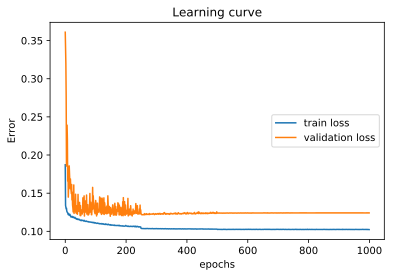

In [42]:
# Plotting the learning curve 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])


plt.title('Learning curve')
# plt.ylabel('Error/Accuracy')
plt.ylabel('Error')
plt.xlabel('epochs')
plt.legend(['train loss', 'validation loss'], loc='center right')
# plt.savefig('/Figures/learning_curve_08Nov.png', bbox_inches='tight')

In [ ]:
# Save trained model 
# serialize model to JSON
model_json = PetroModel.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
PetroModel.save_weights("PetroModel.h5")
print("Saved model to disk")

In [ ]:
# Load saved model
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
PetroModel = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("PetroModel.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

ElasticModel.compile(loss='mean_squared_error', optimizer = adam)


# To evaluate run the "Testing and evaluating the model" cell

In [43]:
# Predict training and test data using the trained network
test_output_petro = PetroModel.predict(X_test_petro)
train_output_petro = PetroModel.predict(X_train_petro)

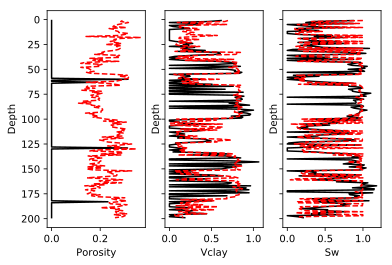

In [44]:
# Checking training data

sample_number = 15
f, axarr = plt.subplots(1, 3, sharey = True)

axarr[0].plot(train_output_petro[sample_number, 0, :], depth, '-k')
axarr[0].plot(Y_train_petro[sample_number, 0, :], depth, '--r')
axarr[0].set_xlabel("Porosity")
axarr[0].set_ylabel("Depth")
axarr[0].invert_yaxis()
# axarr[0].set_xlim(1.5,3.1)

axarr[1].plot(train_output_petro[sample_number, 1, :], depth, '-k')
axarr[1].plot(Y_train_petro[sample_number, 1, :], depth, '--r')
axarr[1].set_xlabel("Vclay")
axarr[1].set_ylabel("Depth")
axarr[1].invert_yaxis()
# axarr[1].set_xlim(1,2)

axarr[2].plot(train_output_petro[sample_number, 2, :], depth, '-k')
axarr[2].plot(Y_train_petro[sample_number, 2, :], depth, '--r')
axarr[2].set_xlabel("Sw")
axarr[2].set_ylabel("Depth")
axarr[2].invert_yaxis()
# axarr[2].set_xlim(1.5,3)

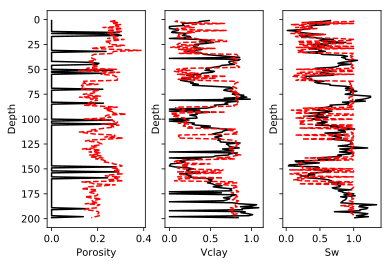

In [34]:
# Checking testing data

sample_number = 12
f, axarr = plt.subplots(1, 3, sharey = True)

axarr[0].plot(test_output_petro[sample_number, 0, :], depth, '-k')
axarr[0].plot(Y_test_petro[sample_number, 0, :], depth, '--r')
axarr[0].set_xlabel("Porosity")
axarr[0].set_ylabel("Depth")
axarr[0].invert_yaxis()
# axarr[0].set_xlim(1.5,3.1)

axarr[1].plot(test_output_petro[sample_number, 1, :], depth, '-k')
axarr[1].plot(Y_test_petro[sample_number, 1, :], depth, '--r')
axarr[1].set_xlabel("Vclay")
axarr[1].set_ylabel("Depth")
axarr[1].invert_yaxis()
# axarr[1].set_xlim(1,2)

axarr[2].plot(test_output_petro[sample_number, 2, :], depth, '-k')
axarr[2].plot(Y_test_petro[sample_number, 2, :], depth, '--r')
axarr[2].set_xlabel("Sw")
axarr[2].set_ylabel("Depth")
axarr[2].invert_yaxis()
# axarr[2].set_xlim(1.5,3)

In [59]:
time[1,1] - time[1,0]

0.0009932346197514064

In [36]:
Y_train.shape

(2000, 3, 246)